<center>
<h1>COMP4680/8650: Advanced Topics in Machine Learning</h1>
<h2>ASE: Total Variation Denoising</h2>
Semester 2, 2023<br>
</center>

In [150]:
import torch
from torch import optim
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Intuition and Total Variation Denoising

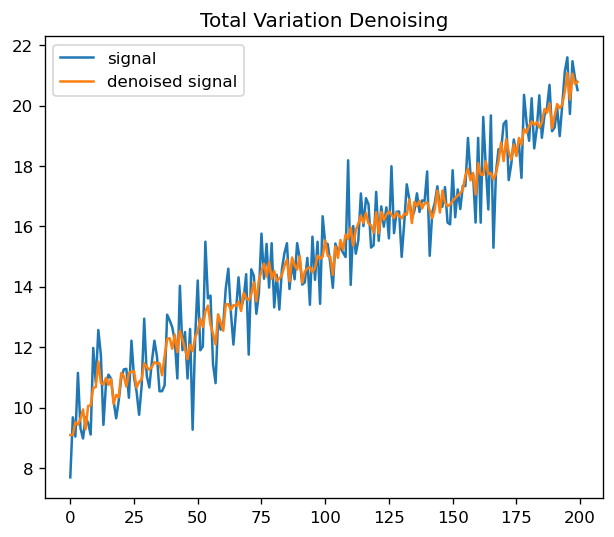

In [208]:
def f(u, x, lmd):
    return 0.5 * torch.sum((u-x)**2) + lmd * torch.sum(torch.abs(u[1:]-u[:-1]))

torch.manual_seed(0)
signal = torch.linspace(10, 20, 200) + torch.randn(200, dtype=torch.double)
lmd = 2
u = torch.nn.Parameter(signal.clone())
optimizer = optim.SGD([u], lr=0.1)
for _ in range(400):
    optimizer.zero_grad()
    loss = f(u, signal, lmd)
    loss.backward()
    optimizer.step()

plt.figure(figsize=(6,5), dpi=120)
plt.plot(signal.detach(), label="signal")
plt.plot(u.detach(),      label="denoised signal")
plt.legend()
plt.title("Total Variation Denoising")
plt.show()

## Function Definition
$$f(u,x)= \frac{1}{2} * \|u-x \|_2^2 + \lambda \sum_{i=1}^{n-1}|u_{i+1} - u_i |$$
$$y(x)  = \min_u f(u,x)$$
By math derivation, we can get the following nice derivative:
$$\frac{\mathrm{d}y}{\mathrm{d}x} = \mathbf{I}$$
where $\mathbf{I}$ is the identity matrix.

In [204]:
def f(u, x, lmd):
    return 0.5 * torch.sum((u-x)**2) + lmd*torch.sum(torch.abs(u[1:]-u[:-1]))

def gradient(u):
   v = np.roll(u,1); v[0]=u[0]
   w = np.roll(u,-1); w[-1]=u[-1]
   return u-signal+lmd*(np.sign(u-v)-np.sign(w-u))

In [239]:
class TotalVariationFcn(torch.autograd.Function):
    """PyTorch autograd function for total variation denoising."""

    @staticmethod
    def forward(ctx, x, lmd):
        with torch.no_grad():
            u = torch.nn.Parameter(x.clone(), requires_grad=True)
            optimiser = optim.SGD([u], lr=0.08)
            for _ in range(200):
                optimiser.zero_grad()
                loss = f(u, x, lmd)
                loss.requires_grad = True
                loss.backward()
                optimiser.step()
            y = u.detach()
        return y

    @staticmethod
    def backward(ctx, dLdY):
        if dLdY is None:
            return None, None
        dLdX = dLdY.clone()
        return dLdX, None

In [240]:
# device = torch.device("cuda")
device = torch.device("cpu")

B, M, N = 1, 10, 5
fcn = TotalVariationFcn.apply

torch.manual_seed(4399)
X = torch.randn((M, 1), dtype=torch.double, device=device, requires_grad=True)

test = gradcheck(fcn, (X, 0.2), eps=1e-6, atol=1e-3, rtol=1e-6)
print("Backward test of DiffPolyFitFcn: {}".format(test))

Backward test of DiffPolyFitFcn: True
